In [1]:
import os
import glob
import time

import numpy as np
import pandas as pd
#IPython.display for audio output
import IPython.display as ipd
# Librosa for audio
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.style as ms
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
np.random.seed(7)

# Supress Tensorflow error logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


Extract MFCCs from 20 ms frames.

In [3]:
def mfcc(y,sr=8000):
    return librosa.feature.mfcc(y=y,sr=sr, n_mfcc=12)

def extract_mfccs(y):
    mfccs_list = []
    ran = len(y)//160
    for i in range(ran-10):
        y_clip = y[160*i:160*(i+1)]
        mfccs_clip = mfcc(y_clip)
        mfccs_clip = np.array(mfccs_clip)
        mfccs_clip = mfccs_clip.flatten()
        mfccs_list.append(mfccs_clip)
    return mfccs_list

In [4]:
# Read all the files from the dataset folder
path_em = 'data/balanced/cleaned_emergency/'
path_nonem = 'data/balanced/nonEmergency/'

em_files = glob.glob(os.path.join(path_em, '*.wav'))
nonem_files = glob.glob(os.path.join(path_nonem, '*.wav'))

In [5]:
X_em = []
for fn in tqdm(em_files):
    y, sr = librosa.load(fn, sr=8000)
    features = extract_mfccs(y)
    X_em.extend(features)

100%|██████████| 123/123 [05:51<00:00,  3.70s/it]


In [6]:
print(len(X_em))

51486


In [7]:
count = 0
X_nonem = []
for fn in tqdm(nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    if len(y) < 64000:
        continue
    else:
        features = extract_mfccs(y)
        X_nonem.extend(features)
        count += 1
        if count == 110:
            break

  7%|▋         | 111/1667 [06:46<1:35:29,  3.68s/it]

In [8]:
print(len(X_nonem))

53647


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def prepare_data(X_em, X_nonem):
    X_em = np.array(X_em)
    X_nonem = np.array(X_nonem)
    
    X = np.vstack((X_em, X_nonem))
    Y = np.hstack((np.ones(len(X_em)), np.zeros(len(X_nonem))))
    
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    X, Y = shuffle(X, Y, random_state=7)
    
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return X, Y, scaler

In [10]:
X_train, Y_train, scaler1 = prepare_data(X_em, X_nonem)

In [11]:
test_path_em = 'data/new_eval/cleaned_emergency/'
test_path_nonem = 'data/eval/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

In [12]:
X_test_em = []
for fn in tqdm(test_em_files):
    y, sr = librosa.load(fn, sr=8000)
    features = extract_mfccs(y)
    X_test_em.extend(features)


100%|██████████| 134/134 [05:34<00:00,  3.90s/it]


In [13]:
count = 0
X_test_nonem = []
for fn in tqdm(test_nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    if len(y) < 64000:
        continue
    else:
        features = extract_mfccs(y)
        X_test_nonem.extend(features)

100%|██████████| 105/105 [06:07<00:00,  4.82s/it]


In [14]:
X_test, Y_test, scaler2 = prepare_data(X_test_em, X_test_nonem)

In [15]:
model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')
callbacks_list = [earlystop]

In [17]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=512)
model.save("model_hi.h5")
print("Saved model to disk!")

Train on 105133 samples, validate on 102799 samples
Epoch 1/100
105133/105133 [==============================] - 2s - loss: 0.7684 - acc: 0.7826 - val_loss: 0.6589 - val_acc: 0.7245
Epoch 2/100
105133/105133 [==============================] - 1s - loss: 0.3993 - acc: 0.8268 - val_loss: 0.6088 - val_acc: 0.7354
Epoch 3/100
105133/105133 [==============================] - 1s - loss: 0.3709 - acc: 0.8391 - val_loss: 0.6074 - val_acc: 0.7393
Epoch 4/100
105133/105133 [==============================] - 2s - loss: 0.3568 - acc: 0.8458 - val_loss: 0.5908 - val_acc: 0.7390
Epoch 5/100
105133/105133 [==============================] - 2s - loss: 0.3473 - acc: 0.8506 - val_loss: 0.5818 - val_acc: 0.7422
Epoch 6/100
105133/105133 [==============================] - 1s - loss: 0.3379 - acc: 0.8562 - val_loss: 0.5870 - val_acc: 0.7432
Epoch 7/100
105133/105133 [==============================] - 2s - loss: 0.3302 - acc: 0.8596 - val_loss: 0.5759 - val_acc: 0.7481
Epoch 8/100
105133/105133 [===========

/anaconda/envs/research/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161982). Check your callbacks.
  % delta_t_median)
/anaconda/envs/research/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109164). Check your callbacks.
  % delta_t_median)


105133/105133 [==============================] - 2s - loss: 0.3136 - acc: 0.8699 - val_loss: 0.5816 - val_acc: 0.7571
Epoch 12/100
105133/105133 [==============================] - 1s - loss: 0.3133 - acc: 0.8698 - val_loss: 0.5943 - val_acc: 0.7554
Epoch 13/100
105133/105133 [==============================] - 2s - loss: 0.3086 - acc: 0.8724 - val_loss: 0.5701 - val_acc: 0.7602
Epoch 14/100
105133/105133 [==============================] - 2s - loss: 0.3071 - acc: 0.8735 - val_loss: 0.5794 - val_acc: 0.7612
Epoch 15/100
105133/105133 [==============================] - 2s - loss: 0.3044 - acc: 0.8743 - val_loss: 0.5774 - val_acc: 0.7602
Epoch 16/100
105133/105133 [==============================] - 2s - loss: 0.3010 - acc: 0.8765 - val_loss: 0.5882 - val_acc: 0.7594
Epoch 17/100
105133/105133 [==============================] - 1s - loss: 0.2999 - acc: 0.8767 - val_loss: 0.5759 - val_acc: 0.7610
Epoch 18/100
105133/105133 [==============================] - 1s - loss: 0.2989 - acc: 0.8777 - 

105133/105133 [==============================] - 1s - loss: 0.2775 - acc: 0.8887 - val_loss: 0.5821 - val_acc: 0.7668
Epoch 74/100
105133/105133 [==============================] - 1s - loss: 0.2774 - acc: 0.8883 - val_loss: 0.5882 - val_acc: 0.7653
Epoch 75/100
105133/105133 [==============================] - 1s - loss: 0.2782 - acc: 0.8881 - val_loss: 0.5935 - val_acc: 0.7632
Epoch 76/100
105133/105133 [==============================] - 1s - loss: 0.2765 - acc: 0.8879 - val_loss: 0.5886 - val_acc: 0.7665
Epoch 77/100
105133/105133 [==============================] - 1s - loss: 0.2773 - acc: 0.8886 - val_loss: 0.6073 - val_acc: 0.7647
Epoch 78/100
105133/105133 [==============================] - 1s - loss: 0.2766 - acc: 0.8888 - val_loss: 0.5846 - val_acc: 0.7664
Epoch 79/100
105133/105133 [==============================] - 2s - loss: 0.2762 - acc: 0.8888 - val_loss: 0.5886 - val_acc: 0.7650
Epoch 80/100
105133/105133 [==============================] - 2s - loss: 0.2759 - acc: 0.8886 - 

In [18]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('model_history.png')

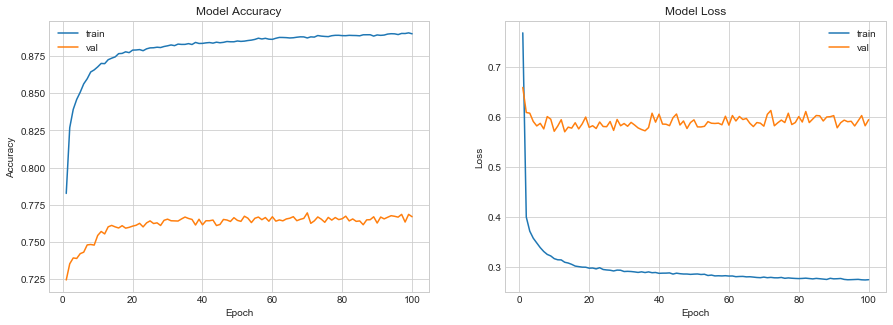

In [19]:
plot_model_history(history)

102656/102799 [============================>.] - ETA: 0s

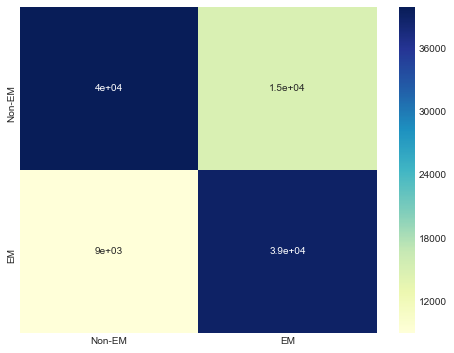

In [20]:
Y_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_pred, Y_test)
df_cm = pd.DataFrame(cm, index = ['Non-EM', 'EM'],
                  columns = ['Non-EM', 'EM'])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu')

## Post processing filtering
Average output over 20 frames to reduce noisy results. 

In [21]:
#test_file = 'data/EmergencySoundSegmented/2017_08_25_11_01AM_activity_2497.19_2508.88.wav'
#test_file = 'data/EmergencySoundSegmented/2017_08_25_11_01AM_activity_2582.98_2593.18.wav'
#test_file = 'data/EmergencySoundSegmented/2017_08_25_11_01AM_activity_2638.78_2647.18.wav'
test_file = 'data/eval/emergency/17.wav'
y, sr = librosa.load(test_file, sr=8000)
ipd.Audio(test_file)

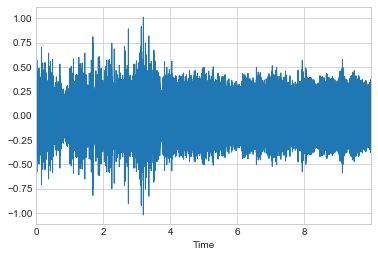

In [22]:
librosa.display.waveplot(y=y, sr=sr)

In [23]:
def predict_prob(y, scaler):
    mfccs_list = extract_mfccs(y)
    scaler.transform(mfccs_list)
    count = 0
    N = 20
    th = 0.5
    
    model = load_model('model.h5')
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(mfccs_list[i].reshape(1,12), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(mfccs_list)):
        prob_list.pop(0)
        p = model.predict(mfccs_list[i].reshape(1,12), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    return class_list

In [24]:
classes = predict_prob(y, scaler2)

## Plot with time axis

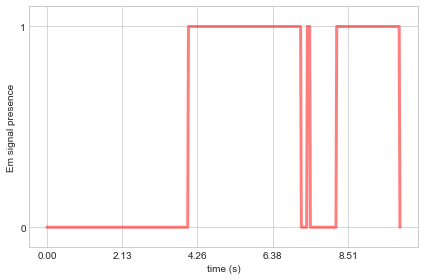

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(classes, c='r', linewidth = 3.0, alpha=0.5)
scale_x = len(classes)/10.0
ticks_x = ticker.FuncFormatter(lambda x, pos: '%.2f'%(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)
ax.set_yticks([0,1])
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel("time (s)")
ax.set_ylabel("Em signal presence")
plt.grid('on')
plt.tight_layout()
plt.show()

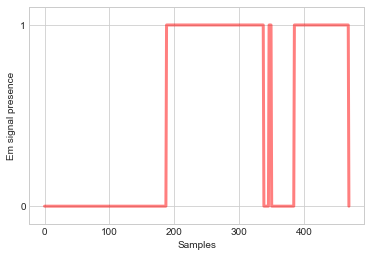

In [26]:
plt.figure()
plt.plot(classes, c='r', linewidth = 3.0, alpha=0.5)
plt.yticks([0,1])
plt.ylim([-0.1,1.1])
plt.xlabel("Samples")
plt.ylabel("Em signal presence")
plt.grid('on')
plt.show()

## Test Accuracy

In [27]:
def predict_op(y, scaler):
    mfccs_list = extract_mfccs(y)
    scaler.transform(mfccs_list)
    count = 0
    N = 20
    th = 0.5
    
    model = load_model('model.h5')
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(mfccs_list[i].reshape(1,12), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(mfccs_list)):
        prob_list.pop(0)
        p = model.predict(mfccs_list[i].reshape(1,12), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    if np.mean(class_list) > 0.5:
        return 1
    else:
        return 0

In [28]:
test_path_em = 'data/new_eval/cleaned_emergency/'
test_path_nonem = 'data/eval/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

tot = 0
correct_em = 0
op_list = []
for test_file in tqdm(test_em_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 1:
        correct_em += 1
    tot += 1

100%|██████████| 134/134 [20:17<00:00, 11.06s/it]


In [29]:
print(correct_em, tot)

105 134


In [30]:
tot = 0
correct_nonem = 0
op_list = []
for test_file in tqdm(test_nonem_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 0:
        correct_nonem += 1
    tot += 1

100%|██████████| 105/105 [28:28<00:00, 17.39s/it]


In [31]:
print(correct_nonem, tot)

94 105
